In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import os
import sys
import numpy as np
import healpy as hp
import healsparse
import matplotlib.pyplot as plt
from scipy.spatial import SphericalVoronoi
from sklearn.neighbors import BallTree

# Load the map:

In [2]:
#load data
path = '/global/cscratch1/sd/xuod/HOS_sims/L845/HACC150/' #directory
nside_c = 32 #nside for healsparse, which uses a lower resolution to define empty regions on the sphere

nshells = 19 #number of mass shells

what = 'kappa' #kappa or shear
seed = 1 #random seed

nzs = 'kappa_Euclid_dndz_fu08_bin1-5' #source redshift distribution - euclid-like
iz = 3 #tomographic bin

file = f'shells_z{nshells}_subsampleauto_groupiso/{nzs}/{what}_hacc_nz{iz}_nside4096_seed{seed}.fits' #file

data = healsparse.HealSparseMap.read(os.path.join(path,file)) #load the file

# Plot the map:

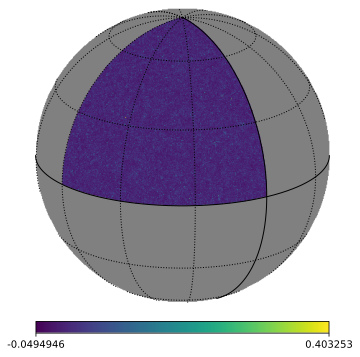

In [3]:
kappa_map = data.generate_healpix_map() #generate the full sky healpix map from healsparse map 
#(empty cells will have value of -1.6375e+30 )

hp.orthview(kappa_map,rot=(35,20), half_sky=True, title = None) #plot map with healpy
hp.graticule() #add latitude and longitude lines

# Plot the mask:

In [4]:
kappa_masked = hp.ma(kappa_map) #generate a healpy object with the map data and the map mask

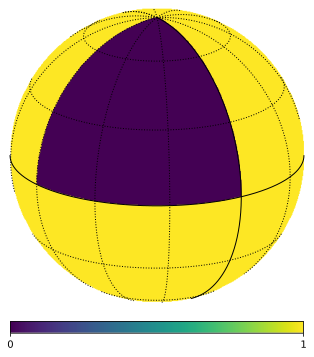

In [5]:
hp.orthview(kappa_masked.mask,rot=(35,20), half_sky=True, title = None) #plot the mask
hp.graticule() #add latitude and longitude lines

# Smooth and plot the map:

In [6]:
#add a flag and an if statement so we don't smooth the map if we already have it saved
load = True

sl_arcmin=10.25 #define the smoothing length for the map in arcmins
sl_rad = sl_arcmin/60/180*np.pi #convert sl_arcmin to radians 

if not load:
    kappa_masked_smooth = hp.smoothing(kappa_masked,sigma = sl_rad) #smooth map with a Gaussian filter with std = sl_rad

    #save the smoothed map so we don't have to do this everytime we start the notebook
    hp.write_map("./smoothed_map.fits",kappa_masked_smooth)

In [7]:
#load the smooth map if it exists
kappa_load = hp.read_map("./smoothed_map.fits")
kappa_masked_smooth = hp.ma(kappa_load) #we need to create the healpy object with a mask again, as these properties are not saved

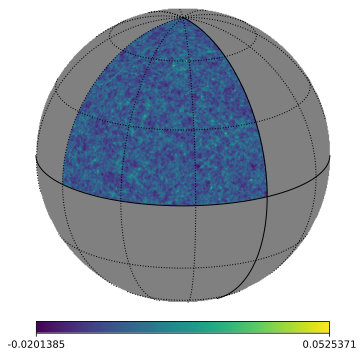

In [8]:
hp.orthview(kappa_masked_smooth, rot=(35,20), half_sky=True, title = None) #plot smoothed map
hp.graticule() #add latitude and longitude lines

# Find and plot the PDFs:

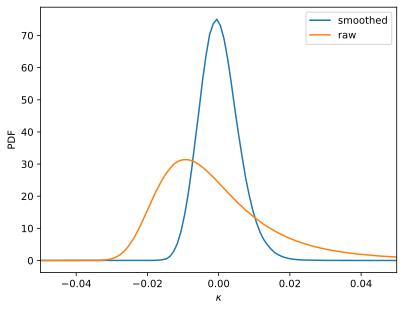

In [9]:
#calculate the pdf of the raw map and the smooth map
kappa_data_smooth = kappa_masked_smooth.data[kappa_masked_smooth.mask==False]
kappa_data = kappa_masked.data[kappa_masked.mask==False]

#choose kappa bins
bins=np.linspace(-0.1-0.001,0.1+0.001,201) 
binmids=(bins[1:]+bins[:-1])/2

#create histograms
counts_smooth,bins=np.histogram(kappa_data_smooth,density=True,bins=bins)
counts,bins=np.histogram(kappa_data,density=True,bins=bins)

#plot results
plt.plot(binmids,counts_smooth,label='smoothed')
plt.plot(binmids,counts,label='raw')
plt.legend()
plt.xlim(-0.05,0.05)
plt.xlabel('$\\kappa$')
plt.ylabel('PDF')
plt.show()

# Define a function to find peaks and minima:

In [10]:
def find_extrema(kappa_map,minima=False,lonlat=False):
    """find extrema in a smoothed masked healpix map
       default is to find peaks, finds minima with minima=True
    
       Parameters
       ----------
       kappa_masked_smooth: MaskedArray (healpy object)
           smoothed masked healpix map for which extrema are to be identified
       minima: bool
           if False, find peaks. if True, find minima
       
       Returns
       -------
       extrema_pos: np.ndarray
           extrema positions on sphere, theta and phi, in radians
       extrema_amp: np.ndarray
           extrema amplitudes in kappa
       
    """

    #first create an array of all neighbours for all valid healsparse pixels
    nside = hp.get_nside(kappa_map) #get nside
    ipix = np.arange(hp.nside2npix(nside))[kappa_map.mask==False] #list all pixels and remove masked ones
    neighbours = hp.get_all_neighbours(nside, ipix) #find neighbours for all pixels we care about

    #get kappa values for each pixel in the neighbour array
    neighbour_vals = kappa_map.data[neighbours.T]
    #get kappa values for all valid healsparse pixels
    pixel_val = kappa_map.data[ipix]

    #compare all valid healsparse pixels with their neighbours to find extrema
    if minima:
        extrema = np.all(np.tile(pixel_val,[8,1]).T < neighbour_vals,axis=-1)
    else:
        extrema = np.all(np.tile(pixel_val,[8,1]).T > neighbour_vals,axis=-1)

        
    #print the number of extrema identified
    if minima:
        print(f'number of minima identified: {np.where(extrema)[0].shape[0]}')
    else:
        print(f'number of peaks identified: {np.where(extrema)[0].shape[0]}')

    extrema_pos = np.asarray(hp.pix2ang(nside, ipix[extrema],lonlat=lonlat)).T #find the extrema positions
    extrema_amp = kappa_map[ipix][extrema].data #find the extrema amplitudes
    
    return extrema_pos, extrema_amp

# Find and plot peaks and minima

In [11]:
#find the peak positions and amplitudes
peak_pos, peak_amp = find_extrema(kappa_masked_smooth,lonlat=True)
#repeat for minima
minima_pos, minima_amp = find_extrema(kappa_masked_smooth,minima=True,lonlat=True)

number of peaks identified: 5622
number of minima identified: 5247


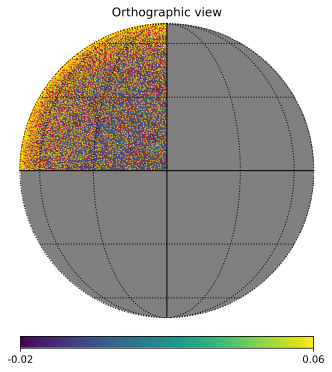

In [12]:
#plot the peaks on top of the kappa map in orthview
hp.orthview(kappa_masked_smooth,min = -0.02,max = 0.06, half_sky=True)
hp.projscatter(peak_pos.T,marker = '.',s=0.5,color='red',lonlat=True)
hp.projscatter(minima_pos.T,marker = '.',s=0.5,color='yellow',lonlat=True)
hp.graticule()

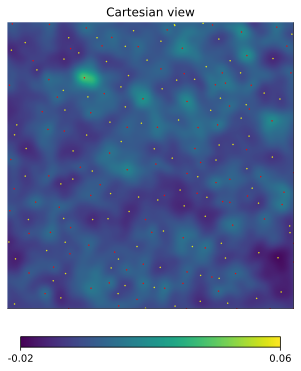

In [13]:
#plot the peaks and minima on top of the kappa map in cartesian view so that we can zoom in and check them
hp.cartview(kappa_masked_smooth,min = -0.02,max = 0.06,lonra=[0,10],latra=[0,10])
hp.projscatter(peak_pos.T,marker = '.',s=1,color='red',lonlat=True)
hp.projscatter(minima_pos.T,marker = '.',s=1,color='yellow',lonlat=True)
hp.graticule()

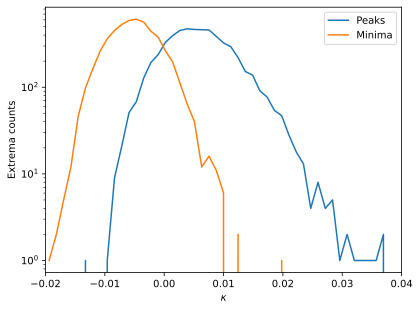

In [14]:
#plot the peak and minima abundances

#choose kappa bins
bins=np.linspace(-0.02,0.04,50) #typical ranges and number of bins
binmids=(bins[1:]+bins[:-1])/2

#create histograms
counts_peaks,bins=np.histogram(peak_amp,density=False,bins=bins)
counts_minima,bins=np.histogram(minima_amp,density=False,bins=bins)

#plot results
plt.semilogy(binmids,counts_peaks,label='Peaks')
plt.semilogy(binmids,counts_minima,label='Minima')
plt.legend()
plt.xlim(-0.02,0.04)
plt.xlabel('$\\kappa$')
plt.ylabel('Extrema counts')
plt.show()

In [15]:
#Things to add:
#peak two-point correlation function code
#void code
#trim statistics near mask